In [1]:
import re
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torch.optim import Adam
from tqdm import tqdm
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split

from BertModel import Dataset, BertClassifier

c:\Users\sgfri\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
MAX_TOKEN_LENGTH = 64
EPOCHS = 2
LR = 1e-6
BATCH_SIZE = 4
LABEL_COLUMN = 'label'

In [3]:
train_df = pd.read_excel("../Scrapper_New/Data_Files/Final/CrimevsNonCrime.xlsx")
print(train_df.describe())
print(f"All entries unique: {train_df['Title'].nunique()==train_df.shape[0]}")
print(f"Null cells: {train_df.isnull().sum().sum()}")

                                                    Title  Label
count                                               16864  16864
unique                                              16330      2
top     FIFA takes on EA Sports video game in soccer’s...  Crime
freq                                                    4   8641
All entries unique: False
Null cells: 0


In [4]:
train_df.drop_duplicates(subset=['Title'], inplace=True, ignore_index=True, keep='first')
print(f"All entries unique: {train_df['Title'].nunique()==train_df.shape[0]}")

All entries unique: True


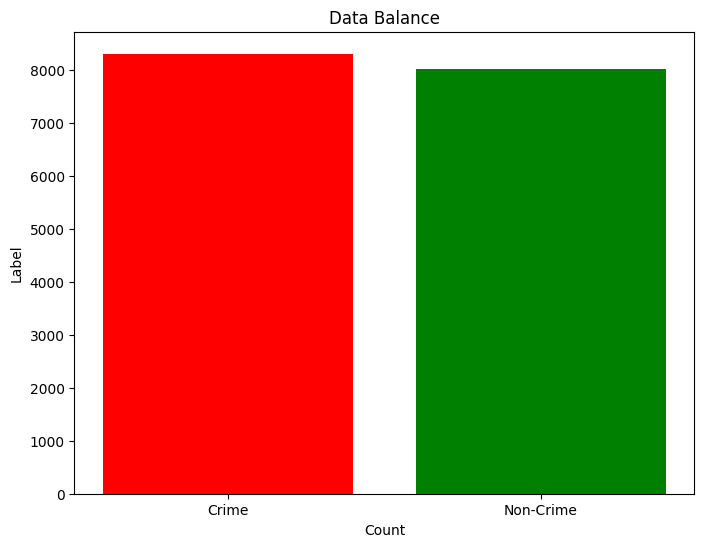

In [5]:
column_list = ['text', 'label', 'word_count']
if not LABEL_COLUMN in column_list:
    raise Exception("Label name in 'filtered_df' do not match with LABEL_COLUMN. Check the label columns and add them to LABEL_COLUMN")

filtered_df = pd.DataFrame(columns=column_list)

filtered_df['label'] = (pd.Categorical(train_df['Label']).codes).astype(int)
label_counts = train_df['Label'].value_counts()

plt.figure(figsize=(8, 6))
plt.bar(label_counts.index, label_counts, color=['red', 'green'])
plt.xlabel('Count')
plt.ylabel('Label')
plt.title('Data Balance')
plt.show()

Average Word count: 12.005939987752603


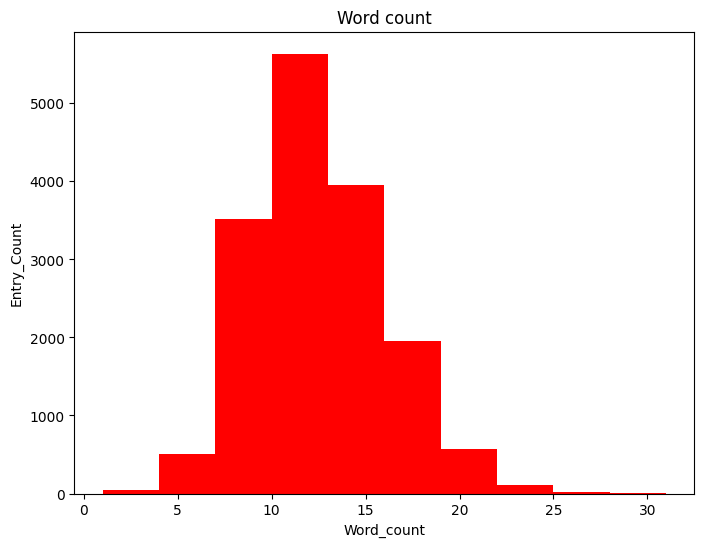

In [6]:
text_list = []
word_count = []

for entry in train_df['Title']:
    new_text = re.sub("[^a-zA-Z ]", " ", entry)
    new_text = new_text.lower().split()
    word_count.append(len(new_text))
    new_text = ' '.join(new_text)
    text_list.append(new_text)

filtered_df['text'] = text_list
filtered_df['word_count'] = word_count

plt.figure(figsize=(8, 6))
print(f'Average Word count: {np.average(word_count)}')
plt.hist(word_count,color='red')
plt.title('Word count')
plt.xlabel('Word_count')
plt.ylabel('Entry_Count')
plt.show()

In [7]:
# X_train, X_test, y_train, y_test = train_test_split(filtered_df['text'],filtered_df['label'], stratify=filtered_df['label'])
# X_train.head()

In [8]:
bert_df = filtered_df.drop(columns=['word_count'])
df_train, df_val, df_test = np.split(bert_df.sample(frac=1, random_state=42), 
                                     [int(.8*len(bert_df)), int(.9*len(bert_df))])

print(len(df_train),len(df_val), len(df_test))
print(train_df.head())

13064 1633 1633
                                               Title  Label
0  Minor raped by cop in Jharkhand's Hazaribagh, ...  Crime
1  'Saw my brother getting killed': Bhilwara vict...  Crime
2  Delhi Police arrests burglar, recovers huge qu...  Crime
3  Pregnant woman raped by hospital staff in UP’s...  Crime
4  Muzaffarpur: 15-year-old girl thrashed, gang-r...  Crime


In [9]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
bert_model = BertModel.from_pretrained('bert-base-cased')
labels = {'Crime':0,
          'Non-crime':1}

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [10]:
def train(model, train_data, val_data, learning_rate, epochs, batch_size):

    train, val = Dataset(train_data, tokenizer, labels, LABEL_COLUMN), Dataset(val_data, tokenizer, labels, LABEL_COLUMN)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=batch_size)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label.long())
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label.long())
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
        
            print(
                f"Epochs: {epoch_num + 1} \
                    | Train Loss: {total_loss_train / len(train_data): .3f} \
                    | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                    | Val Loss: {total_loss_val / len(val_data): .3f} \
                    | Val Accuracy: {total_acc_val / len(val_data): .3f}")
                  

In [30]:
def evaluate(model, test_data, batch_size):
    
    test = Dataset(test_data, tokenizer, labels, LABEL_COLUMN)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=batch_size)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)

              acc = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')

In [19]:
model = BertClassifier(bert_model)
              
train(model, df_train, df_val, LR, EPOCHS, BATCH_SIZE)

100%|██████████| 3266/3266 [13:16:51<00:00, 14.64s/it]  


Epochs: 1 | Train Loss:  0.142                 | Train Accuracy:  0.788                 | Val Loss:  0.084                 | Val Accuracy:  0.871


100%|██████████| 3266/3266 [13:40:53<00:00, 15.08s/it]  


Epochs: 2 | Train Loss:  0.071                 | Train Accuracy:  0.889                 | Val Loss:  0.070                 | Val Accuracy:  0.896


In [28]:
torch.save(model.state_dict(), './Bert_Weights/Bert_E2_896.pt')
torch.save(model, './Bert_Weights/Bert_E2_896')

In [29]:
new_model = BertClassifier(bert_model)
new_model.load_state_dict(torch.load('./Bert_Weights/Bert_E2_896.pt'))

<All keys matched successfully>

In [31]:
evaluate(new_model, df_test, BATCH_SIZE)

Test Accuracy:  0.877
